In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd drive
# %cd 'My Drive'
# %cd 'IS projects'
# %cd CL
# %cd DataSets


/content/drive
/content/drive/My Drive
/content/drive/My Drive/IS projects
/content/drive/My Drive/IS projects/CL
/content/drive/My Drive/IS projects/CL/DataSets


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats import multivariate_normal
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import mixture
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from matplotlib import rcParams

In [2]:
def seperation_index(data, cluster_indices, p = 2):

    def intra_distance(cluster, p = 2): #Calculates maximum intra-cluster distance

        if(p ==2):
            return np.amax(pairwise_distances(cluster, metric = "euclidean"))

        else:
            pairwise = np.zeros((len(cluster), len(cluster)))
            for i in range(len(cluster)):
                for j in range(len(cluster)):
                    pairwise[i][j] = np.linalg.norm(cluster[i] - cluster[j], p)
            print(pairwise)
        return np.amax(pairwise)

    def inter_distance(cluster1, cluster2, p = 2):  #Calculates minimum inter-cluster distance (single-link)
        x = np.zeros((len(cluster1), len(cluster2)))
        x = [[np.linalg.norm(cluster1[i]-cluster2[j], p) for i in range(len(cluster1)) ] for j in range(len(cluster2))]
        return np.amin(x)
    
        
    num_clusters = len(np.unique(cluster_indices))
    cluster_mapping = {} # Dictinary; Partitioning data based on cluster indices

    for i in range(num_clusters):
        cluster_mapping[np.unique(cluster_indices)[i]] = data[np.where(cluster_indices == i)]


    temp = []
    if(num_clusters == 1):
        return 0
    
    for j in range(num_clusters):
        
        inner_temp = []
        for i in range(num_clusters):
            if(i!=j):# Iterating over other clusters after fixing one cluster
                
                # Higher Seperation for Algorithm with further clusters:
                num = inter_distance(data[np.where(cluster_indices ==i)], data[np.where(cluster_indices ==j)], p) 
               
                # Higher Seperation for Algorithm with denser clusters 
                den = np.amax([intra_distance(data[np.where(cluster_indices ==l)], p)  for l in range(num_clusters)]) #
                
                # Normalizing numerators across the whole cluster pairs with the denumerator 
                inner_temp.append(num/den) 
                
    temp.append(min(inner_temp)) 

    seperation_index = min(temp) # Assuming a pessimistic lowerbound along the seperation metric for all pairs

    return seperation_index
        

In [3]:
def fisher_index(data, cluster_indices):
    num_clusters = len(np.unique(cluster_indices))
    data_dimension = len(data[0])
    
    epsilon = (np.amax(data)-np.amin(data))/(10**5) # Preventing Singularity of Sw
    clusters = {} # Dictinary; Partitioning data based on cluster indices

    for i in range(num_clusters):
        clusters[np.unique(cluster_indices)[i]] = data[np.where(cluster_indices == i)]

    if(num_clusters==1):
        return 0
    
    centroids = []
    
    Sw = np.zeros((data_dimension, data_dimension))
    for i in range(len(clusters)):
        Si = np.zeros((data_dimension, data_dimension))
        for q in range(len(clusters[i])):
            
            # Calculating Variance Matrix to obtain Si & Sw
            mul = np.matmul(np.transpose(np.array([clusters[i][q] - np.mean(clusters[i][q])])), np.array([clusters[i][q] - np.mean(clusters[i][q])]))
            Si = np.add(Si, mul)
            
        centroids.append(np.mean(clusters[i], axis = 0)) # Calculating Clusters Centroids
    Sw = np.add(Sw, Si)
    
    
    total_centroid  = np.mean(centroids, axis = 0) # Calculating Between Cluster Covariability using Centroids Covariance Matrix
    Sb = np.zeros((data_dimension, data_dimension))
    
    for i in range(num_clusters):
        Sb = np.add(Sb, np.matmul(np.transpose(np.array([(centroids[i] - (total_centroid))])), np.array([(centroids[i] - (total_centroid))])))
    
    Sw = np.add(Sw, epsilon*np.eye(data_dimension))
    FDI = np.trace(np.matmul(np.linalg.inv(Sw), Sb)) 
    return FDI


In [4]:
def barchart_comparison(algorithms, seperations, fdis, clr = '#ccbfde', title = None): #Gets list of Algorithm Names and Corresponding Seo, Fisher Metrics

    fig, ax = plt.subplots(1, 2, figsize = (20, 7))
    fig.tight_layout(pad = 10.0)

    y_pos = np.arange(len(algorithms))
    ax[0].barh(algorithms, seperations, color = clr)
    ax[0].set_xlabel('Seperation Indices')

    ax[1].barh(algorithms, fdis, color = clr)
    ax[1].set_xlabel('FDI')

    plt.show()

### Reading the data

In [2]:
read_data =  lambda filename :  pd.read_csv(filename).to_numpy()

In [3]:
toy_data_set = read_data('ToyDataSet.csv')

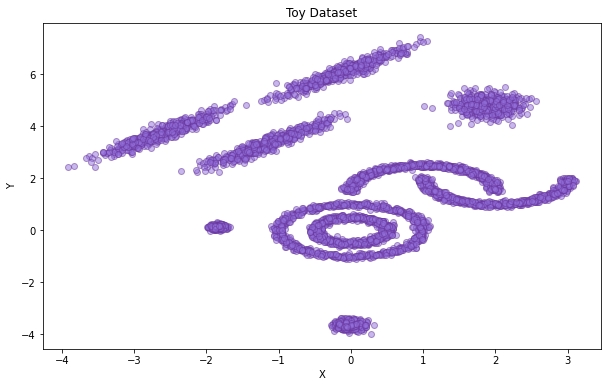

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(toy_data_set[:,0], toy_data_set[:,1], color = 'mediumpurple' ,  alpha = 0.5, edgecolors = 'rebeccapurple')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Toy Dataset')
plt.show()

In [5]:
random_row8 = [4579, 5919, 401, 1139, 5718, 5037, 2531, 3666] #8 - toy
random_row5 = [6315, 899, 8295, 470, 5311] #5 - bb
random_row7 = [12660, 13483, 1922, 9099, 12557, 13450, 9134] #7 - bb 
random_row3  = [5291, 99, 9104] #3 - bb 
rndom_row =  [random_row3, random_row3, random_row5, random_row7]

In [6]:
class GaussianMixture:
    def __init__(self, n_componets, max_iter, random_row):
        self.n_componets = n_componets
        self.max_iter = int(max_iter)
        self.random_row = random_row

    def initialize(self, data):
        self.shape = data.shape
        self.n, self.m = data.shape
        self.phi = np.full(shape = self.n_componets, fill_value = 1/self.n_componets)
        self.weights = np.full(shape = self.shape, fill_value = 1/self.n_componets)
        #random_row = np.random.randint(low = 0, high = self.n, size = self.n_componets)
        self.mu = [data[row_index,:] for row_index in self.random_row]
        self.sigma = [np.cov(data.T) for _ in range(self.n_componets)]

    def E_step(self, data):
        self.weights = self.predict_proba(data)
        self.phi = self.weights.mean(axis = 0)
    
    def M_step(self, data):
        for i in range(self.n_componets):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (data * weight).sum(axis = 0) / total_weight
            self.sigma[i] = np.cov(data.T, aweights=(weight/total_weight).flatten(), bias=True)

    def fit(self, data):
        self.initialize(data)
        for iteration in range(self.max_iter):
            self.E_step(data)
            self.M_step(data)
            
    def predict_proba(self, data):
        likelihood = np.zeros((self.n, self.n_componets))
        for i in range(self.n_componets):
            distribution = multivariate_normal(mean = self.mu[i], cov = self.sigma[i])
            likelihood[:,i] = distribution.pdf(data) 
        return likelihood * self.phi / (likelihood * self.phi).sum(axis=1)[:, np.newaxis]
    
    def predict(self, data): return np.argmax(self.predict_proba(data), axis = 1)

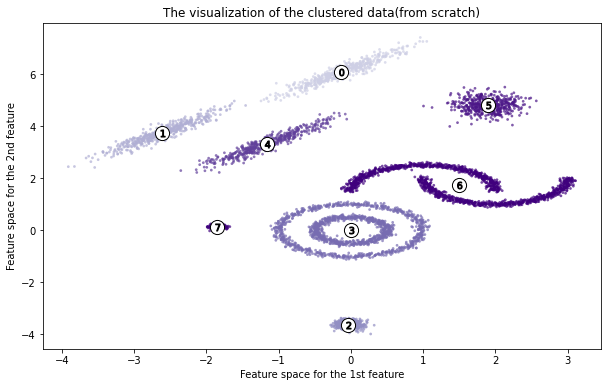

In [7]:
gmm_model = GaussianMixture(8, max_iter = 100, random_row = random_row8)
gmm_model.fit(toy_data_set)
predicted_label = gmm_model.predict(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(predicted_label.astype(float) / np.unique(predicted_label).shape[0] + 0.3 )
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(toy_data_set[predicted_label == i], axis = 0) for i in range(np.unique(predicted_label).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(from scratch)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()


### Metric Evaluation:

In [19]:
# saving metric results 
sep_ind = []
fda_ind = []

sep_ind.append(seperation_index(toy_data_set, predicted_label))
fda_ind.append(fisher_index(toy_data_set,  predicted_label))

print(sep_ind)
print(fda_ind)

[0.08059743231200321]
[391647.8689021558]


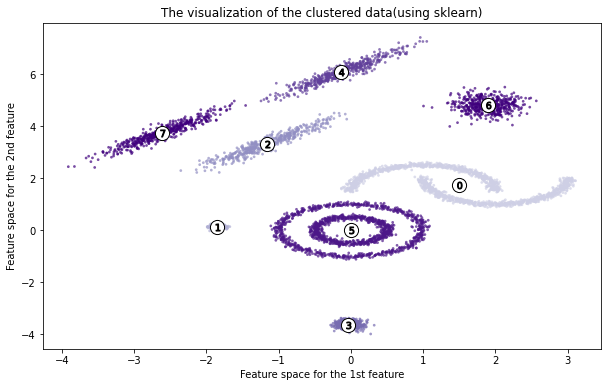

In [8]:
gmm = mixture.GaussianMixture(n_components = 8, random_state = 0).fit(toy_data_set)
predicted_label = gmm.predict(toy_data_set)
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(predicted_label.astype(float) / np.unique(predicted_label).shape[0] + 0.3 )
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
centers = [np.mean(toy_data_set[predicted_label == i], axis = 0) for i in range(np.unique(predicted_label).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data(using sklearn)")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [9]:
probs = gmm.predict_proba(toy_data_set)
print(probs[:10].round(3))

[[0.077 0.    0.    0.    0.    0.923 0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.05  0.    0.    0.    0.    0.95  0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.014 0.    0.    0.    0.    0.986 0.    0.   ]]


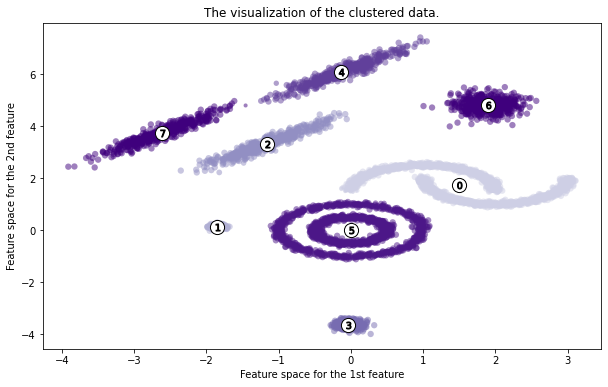

In [10]:
size = 40 * probs.max(1) ** 2  # square emphasizes differences
fig, ax = plt.subplots(figsize=(10, 6))
colors = cm.Purples(predicted_label.astype(float) / np.unique(predicted_label).shape[0] + 0.3 )
ax.scatter(toy_data_set[:, 0], toy_data_set[:, 1], marker = 'o', s = size, lw = 0, alpha = 0.5, c = colors, edgecolor='k')
centers = [np.mean(toy_data_set[predicted_label == i], axis = 0) for i in range(np.unique(predicted_label).shape[0])]
for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
ax.set_title("The visualization of the clustered data.")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
plt.show()

In [11]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, color = 'darkslateblue', **kwargs))

In [12]:
rcParams['figure.figsize'] = 10, 6

def plot_gmm(model, data, label=True, ax=None):
    ax = ax or plt.gca()
    labels = model.fit(data).predict(data)
    if label:
        colors = cm.Purples(labels.astype(float) / np.unique(labels).shape[0] + 0.3 )
        ax.scatter(data[:, 0], data[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
    else:
        ax.scatter(data[:, 0], data[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7)
    
    w_factor = 0.2 / model.weights_.max()
    for pos, covar, w in zip(model.means_, model.covariances_, model.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components"%len(model.means_))
    plt.xlabel("Feature space for the 1st feature")
    plt.ylabel("Feature space for the 2nd feature")

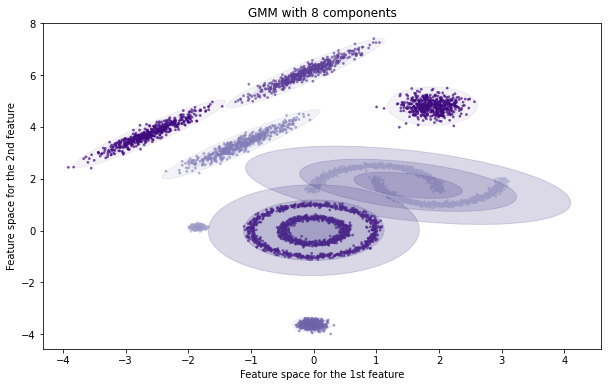

In [13]:
gmm = mixture.GaussianMixture(n_components = 8, random_state = 0) 
plot_gmm(gmm, toy_data_set)

In [24]:
algorithms = ['GMM']
print(f"GMM metrics: separation index: {sep_ind}, fdi: {fda_ind}\n")
#barchart_comparison(algorithms, sep_ind, fda_ind)

GMM metrics: separation index: [0.08059743231200321], fdi: [391647.8689021558]





---

---

---

---




In [25]:
bboxes_data_set = read_data('bboxes.csv')

In [26]:
norm_bboxes = np.zeros((bboxes_data_set.shape[0], 2))
norm_bboxes[:, 0] = (bboxes_data_set[:, 4] - bboxes_data_set[:, 2]) / bboxes_data_set[:, 0]
norm_bboxes[:, 1] = (bboxes_data_set[:, 5] - bboxes_data_set[:, 3]) / bboxes_data_set[:, 1]

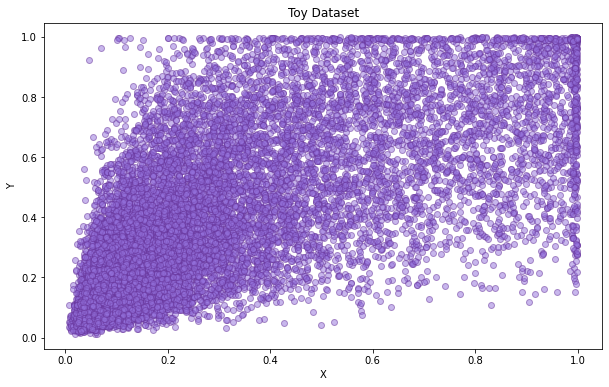

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(norm_bboxes[:,0], norm_bboxes[:,1], color = 'mediumpurple' , alpha = 0.5, edgecolors = 'rebeccapurple')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Toy Dataset')
plt.show()

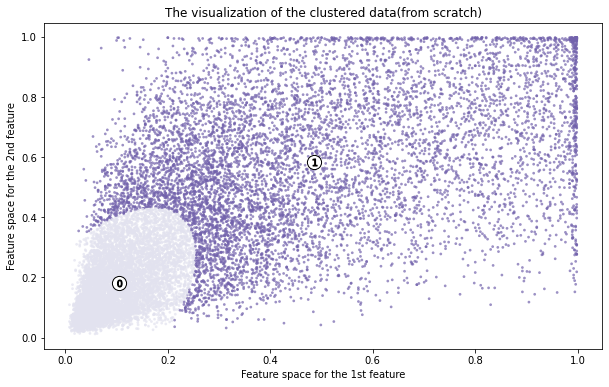

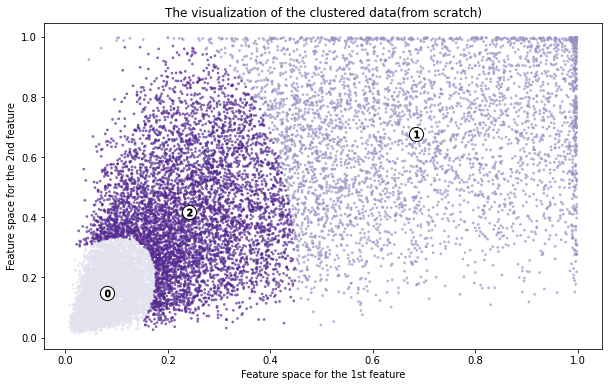

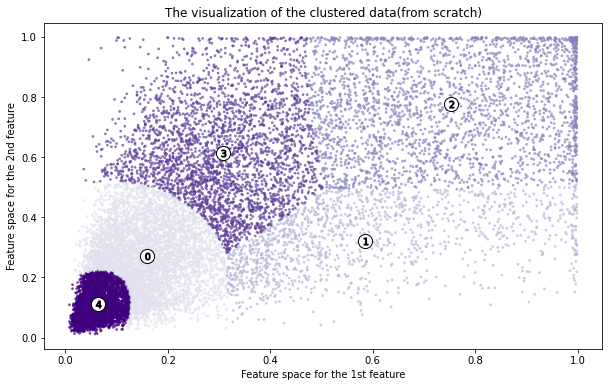

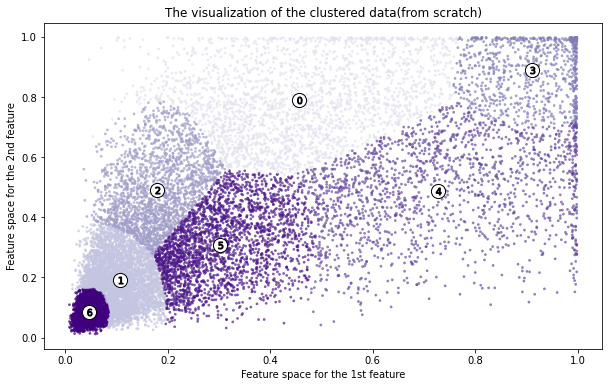

In [28]:
n_components = [2, 3, 5, 7]
for i, n in enumerate(n_components):
  gmm_model = GaussianMixture(n, max_iter = 100, random_row = rndom_row[i] )
  gmm_model.fit(norm_bboxes)
  predicted_label = gmm_model.predict(norm_bboxes)
  fig, ax = plt.subplots(figsize=(10, 6))
  colors = cm.Purples(predicted_label.astype(float) / np.unique(predicted_label).shape[0] + 0.2)
  ax.scatter(norm_bboxes[:, 0], norm_bboxes[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
  centers = [np.mean(norm_bboxes[predicted_label == i], axis = 0) for i in range(np.unique(predicted_label).shape[0])]
  for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
  for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
  ax.set_title("The visualization of the clustered data(from scratch)")
  ax.set_xlabel("Feature space for the 1st feature")
  ax.set_ylabel("Feature space for the 2nd feature")
  plt.show()


In [30]:
# saving metric results 
sep_ind = []
fda_ind = []

sep_ind.append(seperation_index(norm_bboxes, predicted_label))
fda_ind.append(fisher_index(norm_bboxes,  predicted_label))

print(sep_ind)
print(fda_ind)



[0.0011706500562553427]
[106261.55382242883]


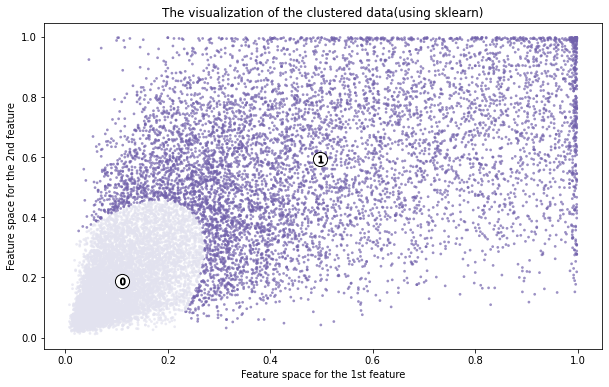

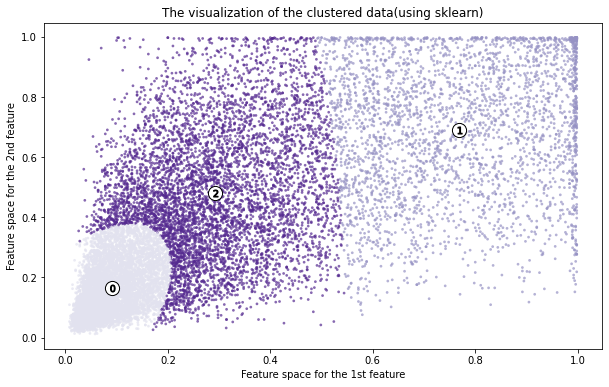

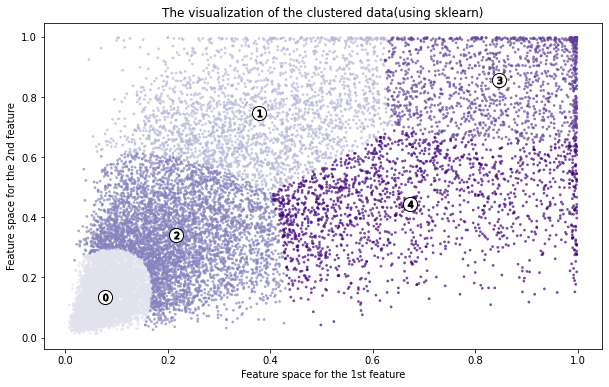

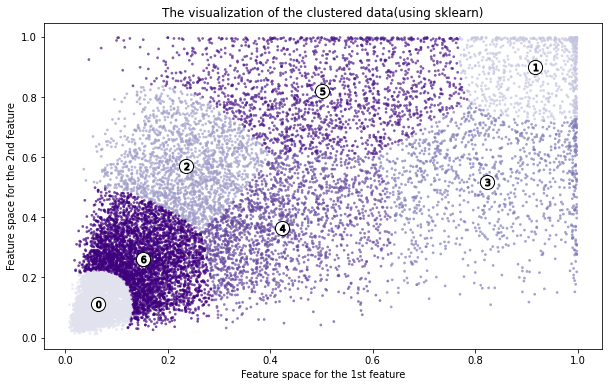

In [ ]:
n_components = [2, 3, 5, 7]
for n in n_components:
    gmm = mixture.GaussianMixture(n, random_state = 0).fit(norm_bboxes)
    labels = gmm.predict(norm_bboxes)
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = cm.Purples(labels.astype(float) / np.unique(labels).shape[0] + 0.2)
    ax.scatter(norm_bboxes[:, 0], norm_bboxes[:, 1], marker = '.', s = 30, lw = 0, alpha = 0.7, c = colors)
    centers = [np.mean(norm_bboxes[labels == i], axis = 0) for i in range(np.unique(labels).shape[0])]
    for i, c in enumerate(centers): ax.scatter(c[0], c[1],  marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers): ax.scatter(c[0], c[1], marker='$%d$' % i, alpha = 1, s=50, edgecolor='k')
    ax.set_title("The visualization of the clustered data(using sklearn)")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")
    plt.show()

In [31]:
algorithms = ['GMM']
print(f"GMM metrics: separation index: {sep_ind}, fdi: {fda_ind}\n")
#barchart_comparison(algorithms, sep_ind, fda_ind)

GMM metrics: separation index: [0.0011706500562553427], fdi: [106261.55382242883]



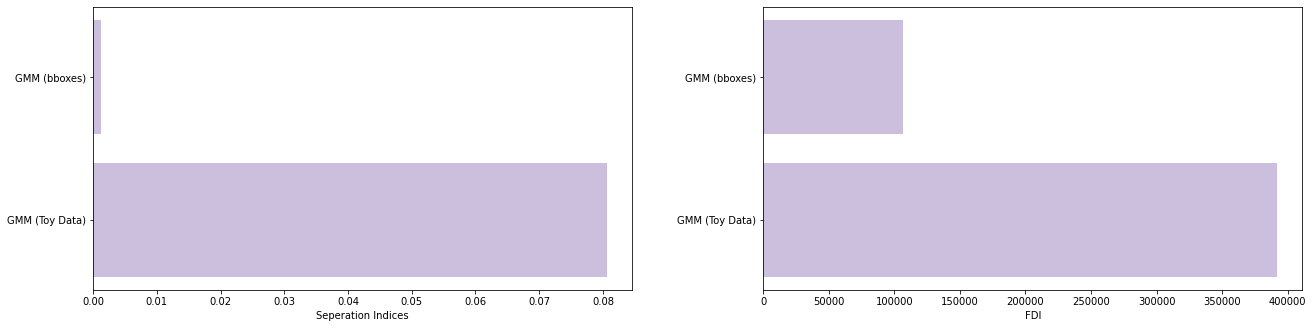

In [7]:
algorithms = ['GMM (Toy Data)', 'GMM (bboxes)']

sep_ind = [0.08059743231200321,0.0011706500562553427]
fdi_ind = [391647.8689021558, 106261.55382242883]

barchart_comparison(algorithms, sep_ind, fdi_ind, clr = '#ccbfde')